In [1]:
# Import PyTorch
import torch
from torch.utils.data import DataLoader
from torch import nn, optim


# Import torchvision 
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

from tqdm.notebook import tqdm
# Import matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 32
LEARNING_RATE = 0.1
torch.manual_seed(42)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


## Data preprocessing and visualization

Loading the Dataset: 

In [4]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)


Check out the first sample of the training data and see the image shape

torch.Size([1, 28, 28])


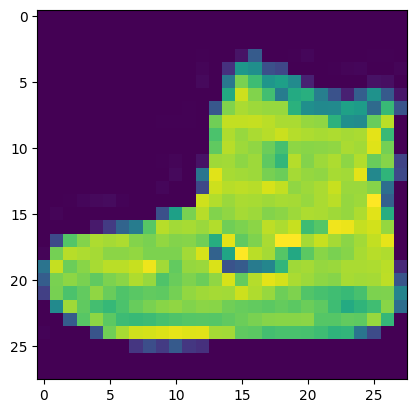

In [5]:
image, label = train_data[0]
print(image.shape)
plt.imshow(image.squeeze())
plt.show()

The  `FashionMNIST`  dataset has a total of 10 classes. Each class represents a specific type of fashion item. The classes in the dataset are as follows:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

These classes represent different categories of clothing and accessories.

In [6]:
labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

def show_image(data, index, labels) -> None:
    print(f"label: {labels[index]}")
    plt.imshow(image.squeeze())
    plt.show()
    

label: T-shirt/top


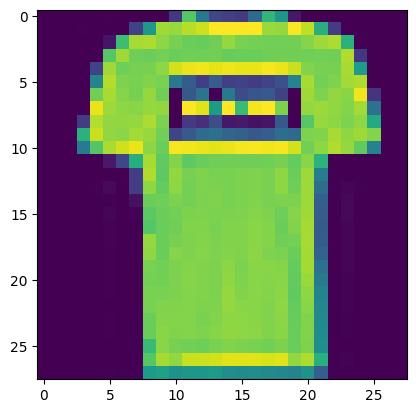

label: Trouser


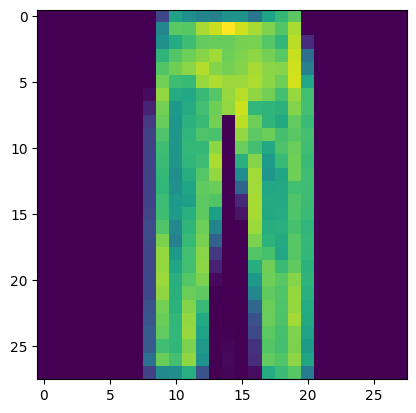

label: Pullover


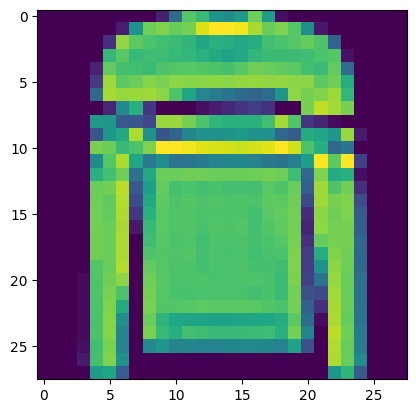

label: Dress


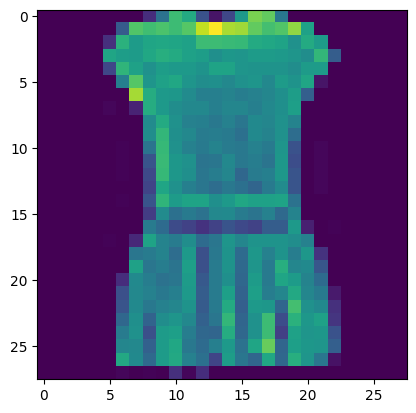

label: Coat


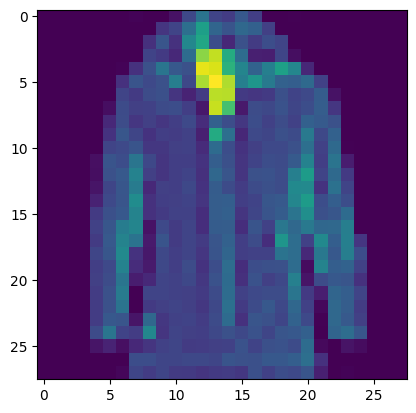

label: Sandal


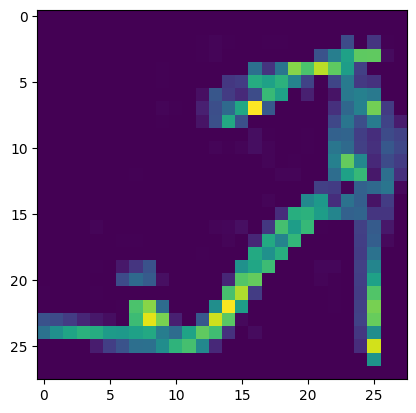

label: Shirt


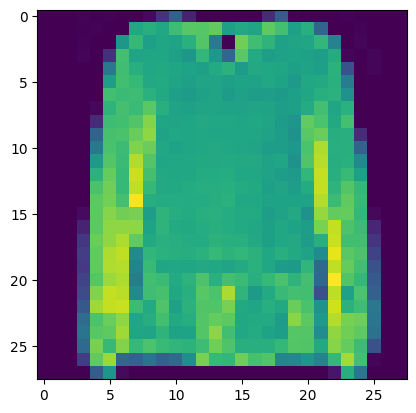

label: Sneaker


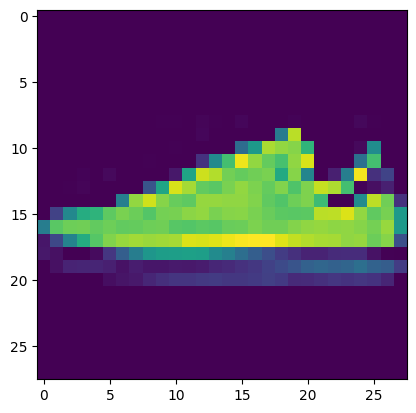

label: Bag


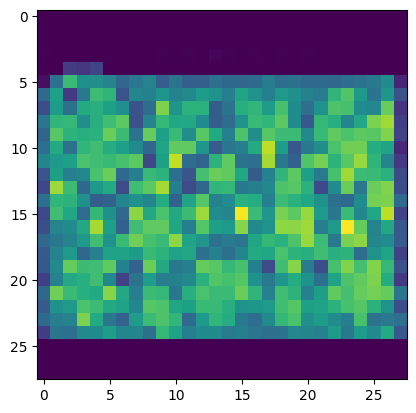

label: Ankle boot


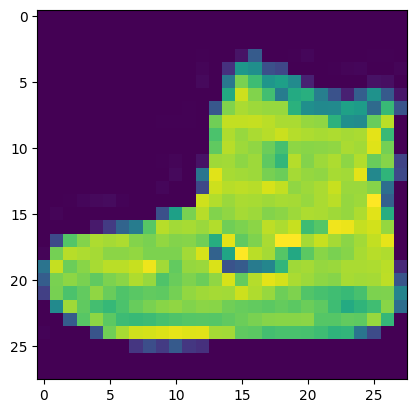

In [7]:
for i in range(10):
    for image, label in train_data:
        if label == i:
            show_image(train_data, i, labels)
            break

## Prepare DataLoader

The use of batches in the training process serves multiple purposes:

- Efficiency: Training a neural network on a large dataset can be computationally expensive. By dividing the dataset into smaller batches, we can process and update the model parameters more frequently, making the training process more efficient.

- Memory requirements: Loading the entire dataset into memory at once may not be feasible if the dataset is too large. Batching allows us to load and process smaller portions of the dataset at a time, reducing memory requirements.

- Generalization: Training on batches of data helps the model generalize better. Each batch contains a random subset of the data, which introduces variability and prevents the model from overfitting to specific examples.

- Stochastic gradient descent (SGD): Batching is particularly useful when using stochastic gradient descent, where the model parameters are updated after each batch. This allows the model to continuously refine its parameters based on the gradients computed from each batch, leading to faster convergence.



Here are some advantages and disadvantages of using very small or big batch sizes in training a neural network:

Advantages of using a small batch size:
- Faster convergence: Smaller batch sizes can lead to faster convergence during training, as the model parameters are updated more frequently. This can be particularly useful when training on large datasets.
- Better generalization: Smaller batch sizes introduce more variability into the training process, which can help the model generalize better to new data.
- Lower memory requirements: Smaller batch sizes require less memory to store the intermediate computations during training.

Disadvantages of using a small batch size:
- Noisier gradients: Smaller batch sizes can result in noisier gradient estimates, as the gradients are computed from a smaller subset of the data. This can make the training process more unstable and lead to slower convergence.
- Slower training: Training with smaller batch sizes can be slower overall, as the model parameters are updated more frequently and the training process requires more iterations.

Advantages of using a large batch size:
- More stable gradients: Larger batch sizes can result in more stable gradient estimates, as the gradients are computed from a larger subset of the data. This can make the training process more stable and lead to faster convergence.
- Faster training: Training with larger batch sizes can be faster overall, as the model parameters are updated less frequently and the training process requires fewer iterations.

Disadvantages of using a large batch size:
- Higher memory requirements: Larger batch sizes require more memory to store the intermediate computations during training, which can be a limiting factor on some hardware.
- Poor generalization: Larger batch sizes can lead to overfitting, as the model may become too specialized to the training data and fail to generalize to new data. 



The  `shuffle`  parameter in  `DataLoader`  is used to shuffle the training data before each epoch during training. Setting  `shuffle=True`  ensures that the data is randomly shuffled before each epoch, which can help prevent the model from overfitting to specific examples and improve the model's generalization performance.

Shuffling the data is particularly important when the data has some inherent ordering, such as time series data or spatial data. In these cases, the order of the data may contain information that the model can exploit, leading to overfitting. Shuffling the data helps remove this ordering and ensures that the model learns to generalize to the data, rather than memorizing specific examples.

In [8]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8
)

The effect of different batch sizes on performance and accuracy can vary depending on the specific problem, model architecture, and dataset. Here are some general considerations:

- Performance: Larger batch sizes can often lead to faster training times due to the potential for parallelization and more efficient memory utilization. This is because processing larger batches can take better advantage of hardware resources like GPUs. However, very large batch sizes may also require more memory, and if the batch size exceeds the available memory, it can lead to slower performance or even out-of-memory errors.

- Accuracy: The choice of batch size can have an impact on the accuracy of the trained model. Smaller batch sizes introduce more randomness and noise into the training process, which can help the model generalize better and potentially improve accuracy. On the other hand, larger batch sizes may provide more stable and accurate gradient estimates, leading to better convergence and potentially higher accuracy.

- Generalization: Smaller batch sizes often promote better generalization as they expose the model to more diverse examples within each epoch. This can help prevent overfitting and improve the model's ability to generalize to unseen data. However, using very small batch sizes can also introduce more noise into the training process, which may hinder convergence and negatively impact accuracy.



## Data Classification

The `nn.Flatten()` layer is used to reshape the input data from a multi-dimensional shape, `[color_channels, height, width]`, to a one-dimensional shape, `[color_channels, height*width]`.

Here are a few reasons why we use `nn.Flatten()`:

- Compatibility with Fully Connected Layers: Many neural network architectures, especially those used for tasks like image classification, often include fully connected layers (also known as dense layers) as the final layers. These fully connected layers require a one-dimensional input. By applying `nn.Flatten()`, we convert the multi-dimensional image representation into a compatible format that can be fed into these fully connected layers.

- Preserving Relationship between Pixels: While the spatial information of an image is lost when flattening it, the relationship between pixels is still preserved in the flattened representation. The flattened tensor still retains the ordering of the pixels from the original image, but in a linear format.

- Efficient Parameterization: Flattening the input data reduces the number of dimensions in subsequent layers, which can lead to more efficient parameterization. Fully connected layers, for example, operate on a one-dimensional input, which allows for a simpler and more compact representation of the model's parameters.

- Generalization across Batch Sizes: The `nn.Flatten()` layer automatically adapts to different batch sizes during training and inference. It ensures that the flattening operation is applied consistently across the entire batch, regardless of the number of samples. This allows the model to process multiple images simultaneously, improving computational efficiency.



In [9]:
class ModelFashionMNIST(nn.Module):
    def __init__(self, input_shape: int, hidden_units1: int, output_shape: int): # You can add more parameters if you wish, e.g. more hidden layers.
        super(ModelFashionMNIST, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),  # Flatten the input shape [color_channels, height, width] to [color_channels, height*width]
            nn.Linear(input_shape, hidden_units1),  # Fully connected layer from input_shape to hidden_units
            nn.ReLU(),  # ReLU activation function
            nn.Linear(hidden_units1, output_shape),  # Fully connected layer from hidden_units to output_shape
        )
    
    def forward(self, x):
        return self.layer_stack(x)

After creating your instance of model, you can use GPU for training it (if available) by the following code:

In [10]:
model = ModelFashionMNIST(input_shape=784, hidden_units1=256, output_shape=10)


#### Setup loss, optimizer and evaluation metrics

In [11]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

#### Implementing training and test loops

In [12]:
epochs = 20

train_losses = []
test_losses = []

for epoch in tqdm(range(epochs)):
    # Training
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        
        # Put model in train mode
        model.train()

        # select the corresponding example and label
        inputs = X  # Assuming X contains the input examples
        labels = y  # Assuming y contains the corresponding labels

        # do a forward pass on the example
        outputs = model(inputs)
        # compute the loss according to your output and the label
        loss = loss_fn(outputs, labels)
        
        # Optimizer zero grad
        optimizer.zero_grad()

        # backward pass
        loss.backward()
        
        # gradient step
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    # Testing
    test_loss, test_acc = 0, 0 
    
    # Put model in test mode
    model.eval()
    
    with torch.inference_mode():
        for X, y in test_dataloader:
            # do a forward pass
            outputs = model(X)  # Forward pass

            # compute the loss
            loss = loss_fn(outputs, y)  # Compute the loss

            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            test_acc += (predicted == y).sum().item()

            # Accumulate the testing loss
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    accuracy = test_acc / len(test_dataloader.dataset)

    # Print the average training loss, test loss, and accuracy for the epoch
    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20: Train Loss: 0.5565, Test Loss: 0.4681, Accuracy: 0.8319
Epoch 2/20: Train Loss: 0.3992, Test Loss: 0.3970, Accuracy: 0.8564
Epoch 3/20: Train Loss: 0.3600, Test Loss: 0.3940, Accuracy: 0.8594
Epoch 4/20: Train Loss: 0.3375, Test Loss: 0.3699, Accuracy: 0.8695
Epoch 5/20: Train Loss: 0.3188, Test Loss: 0.3775, Accuracy: 0.8663
Epoch 6/20: Train Loss: 0.3027, Test Loss: 0.3599, Accuracy: 0.8653
Epoch 7/20: Train Loss: 0.2894, Test Loss: 0.3649, Accuracy: 0.8673
Epoch 8/20: Train Loss: 0.2800, Test Loss: 0.3469, Accuracy: 0.8767
Epoch 9/20: Train Loss: 0.2704, Test Loss: 0.3333, Accuracy: 0.8812
Epoch 10/20: Train Loss: 0.2621, Test Loss: 0.3282, Accuracy: 0.8841
Epoch 11/20: Train Loss: 0.2532, Test Loss: 0.3324, Accuracy: 0.8810
Epoch 12/20: Train Loss: 0.2461, Test Loss: 0.3594, Accuracy: 0.8749
Epoch 13/20: Train Loss: 0.2376, Test Loss: 0.3276, Accuracy: 0.8832
Epoch 14/20: Train Loss: 0.2323, Test Loss: 0.3269, Accuracy: 0.8866
Epoch 15/20: Train Loss: 0.2265, Test Loss:

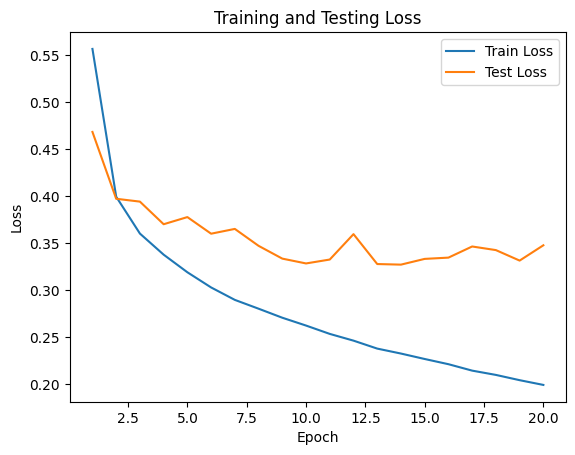

In [13]:
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

##### Implementing Evaluation

In [19]:
def accuracy_fn(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    return correct

In [22]:
def eval_model(model: torch.nn.Module, # A PyTorch model capable of making predictions on data_loader.
               data_loader: DataLoader, # The target dataset to predict on.
               loss_fn: torch.nn.Module, # The loss function of model.
               accuracy_fn, # An accuracy function to compare the models predictions to the truth labels.
               ):

    loss, acc = 0, 0
    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            
            # Make predictions with the model
            outputs = model(X)
            
            # Accumulate the loss 
            loss += loss_fn(outputs, y).item()

            # Accumulate the accuracy
            acc += accuracy_fn(outputs, y)

    # Find the average loss and accuracy across batches
    avg_loss = loss / len(data_loader)
    avg_acc = acc / len(data_loader.dataset)

    # Returns a dictionary containing the results of model predictions on data_loader
    return {f'loss: {avg_loss:.4f}, accuracy: {avg_acc:.4f}'}

In [23]:
eval_model(model,
           test_dataloader,
           loss_fn,
           accuracy_fn
)

{'loss: 0.3475, accuracy: 0.8838'}